In [1]:
from fitparse import FitFile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
from datetime import time
import glob
import requests
from json import JSONDecodeError
import folium
import math
import statsmodels.formula.api as sm
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from statsmodels.nonparametric.smoothers_lowess import lowess
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
df = pd.read_csv('rides.csv')
df['start_station_id'] = df['start_station_id'].astype(int)
df.dtypes

start_station_id         int32
start_date              object
hod                      int64
rides                    int64
month                    int64
dow                      int64
start_station_lat      float64
start_station_long     float64
altitude               float64
distance_to_transit    float64
wind_speed             float64
precipitation          float64
snow                   float64
snow_depth             float64
max_temp               float64
min_temp               float64
dtype: object

# Regression Analysis

So far we have shown a few things.  First of all, my intial regression with all variables in for the first two years is not very effective at prediction.  A large reason for this is likely outliers and insufficient variation.  The dependent variable is heavily biased towards a small number of rides with large outliers.  This reduces the predictive power because so many observations have rides between 0 and 5 rides.

The next model we aggregate to month, dow, hod so 1 observation would be a given hour, for a given dow, in a given month.  Rides for 9AM Tuesday in April are all aggregated to one observation.  This helps with the predictive power by increasing the variation but is weakened because the observations are not tied to a specific date we must drop all weather variables.

Interestingly, aggregating to the day to increase weather does not give as much predictive power as the previous model with a lower $R^2$ value.

## Basic Model
This uses the data as it is brought in with all variables to try and predict rides.  We can see it is not that effective of a prediction tool which is likely because of the distribution of the number of rides.

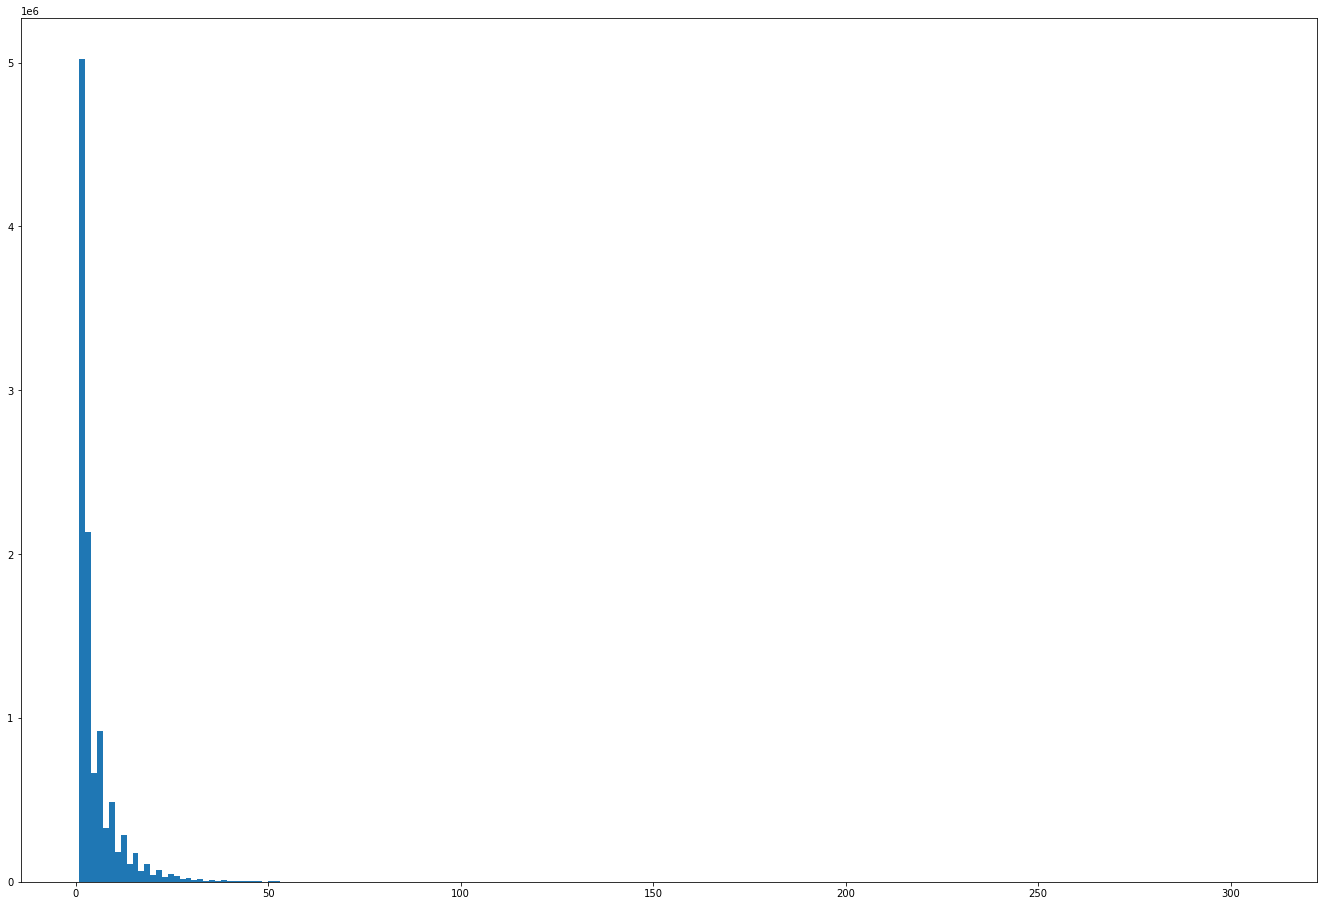

In [2]:
plt.hist(df['rides'],bins = 200)
plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0, hspace=0.2)
plt.show()

In [3]:
model = sm.ols(formula='rides ~  altitude + distance_to_transit + wind_speed + precipitation  + snow + snow_depth + max_temp + min_temp + np.power(distance_to_transit, 2)+ np.power(distance_to_transit, 3) + np.power(max_temp, 2) + np.power(max_temp, 3) + np.power(max_temp, 4) + np.power(wind_speed, 2) + np.power(precipitation, 2) + np.power(precipitation, 3) + C(dow) + C(month) + C(hod)',
                          data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.131
Method:                 Least Squares   F-statistic:                 2.526e+04
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:42:57   Log-Likelihood:            -3.0443e+07
No. Observations:             9399187   AIC:                         6.089e+07
Df Residuals:                 9399130   BIC:                         6.089e+07
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Group to HOD, dow, month
This gives us the highest R squared at 0.174 by increasing the variation we see in the number of rides.  We still have a huge right skew on the distribution but the predictive power is better with less data.  

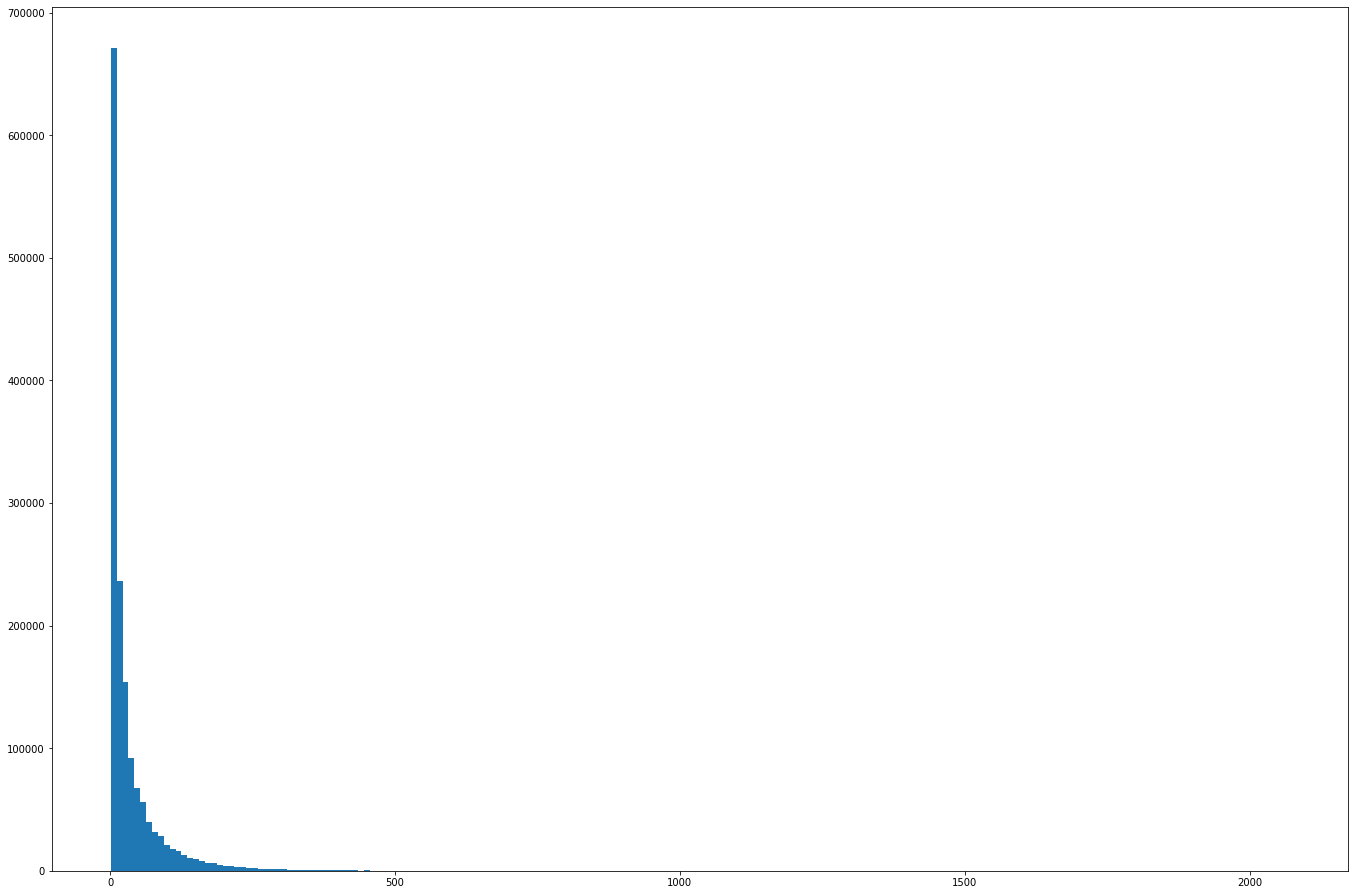

In [4]:
grouped = df.groupby(['start_station_id','month','dow','hod'],as_index = False).rides.sum()
location = df[['start_station_id','altitude','distance_to_transit']].drop_duplicates()
grouped = grouped.join(location.set_index('start_station_id'),on = 'start_station_id')
plt.hist(grouped['rides'],bins = 200)
plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0, hspace=0.2)
plt.show()

In [5]:
grouped = df.groupby(['start_station_id','month','dow','hod'],as_index = False).rides.sum()
location = df[['start_station_id','altitude','distance_to_transit']].drop_duplicates()
grouped = grouped.join(location.set_index('start_station_id'),on = 'start_station_id')
model = sm.ols(formula='rides ~  altitude + distance_to_transit + np.power(distance_to_transit , 3) + np.power(distance_to_transit , 2)  + C(dow) + C(month) + C(hod)',data=grouped).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.180
Model:                            OLS   Adj. R-squared:                  0.180
Method:                 Least Squares   F-statistic:                     7605.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:43:31   Log-Likelihood:            -8.2372e+06
No. Observations:             1527938   AIC:                         1.647e+07
Df Residuals:                 1527893   BIC:                         1.648e+07
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## Aggregate to full day

This aggregates to the full day it is not ideal because we want to predict hourly data but it allows us to aggregate to a higher level to help with variation and keep 

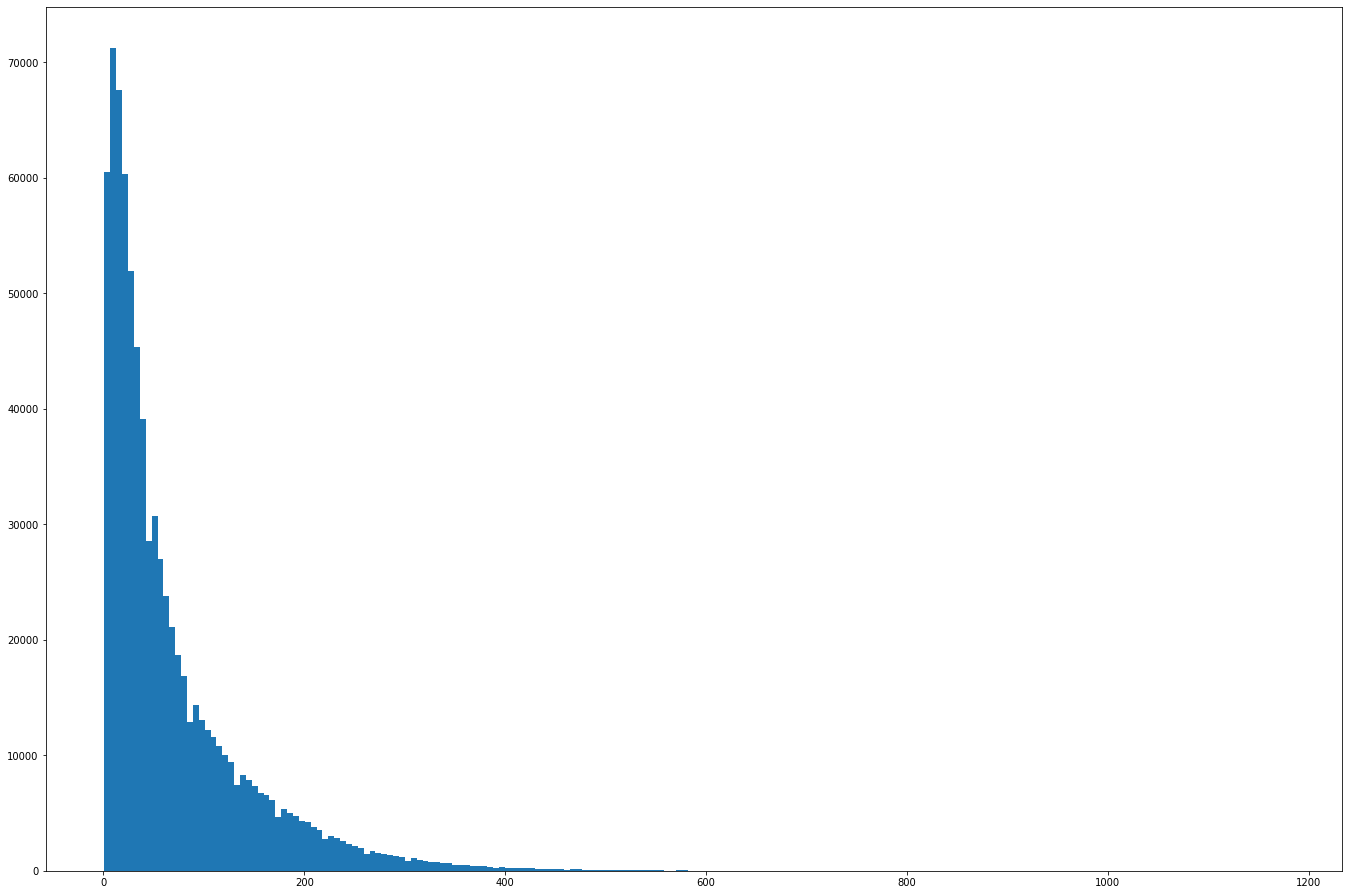

In [6]:
grouped = df.groupby(['start_station_id','start_date','altitude','distance_to_transit'],as_index = False).rides.sum()
date = df[['start_date','month','dow','wind_speed','precipitation','snow','snow_depth','max_temp','min_temp']].drop_duplicates()
grouped = grouped.join(date.set_index('start_date'),on = 'start_date')

plt.hist(grouped['rides'],bins = 200)
plt.subplots_adjust(left=0, bottom=0, right=3, top=3, wspace=0, hspace=0.2)
plt.show()

In [7]:
model = sm.ols(formula='rides ~  altitude + distance_to_transit + np.power(distance_to_transit , 3) + np.power(distance_to_transit , 2)  + wind_speed + precipitation  + snow + snow_depth + max_temp + min_temp + np.power(max_temp, 2) + np.power(wind_speed, 2) + np.power(precipitation, 2)  + C(dow) + C(month) ',
                         data=grouped).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  rides   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     4288.
Date:                Wed, 04 Nov 2020   Prob (F-statistic):               0.00
Time:                        16:43:44   Log-Likelihood:            -3.8086e+06
No. Observations:              669539   AIC:                         7.617e+06
Df Residuals:                  669508   BIC:                         7.618e+06
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

# VISUALIZATIONS

## Rides over time

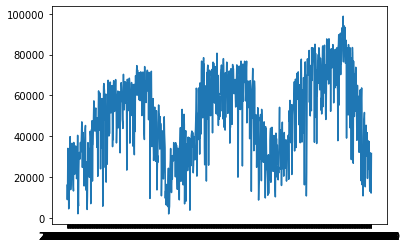

In [8]:
growth = df.groupby(['start_date'],as_index = False).rides.sum()
plt.plot(growth['start_date'],growth['rides'])
plt.show()

## Bar Graph of Rides broken down by year and month

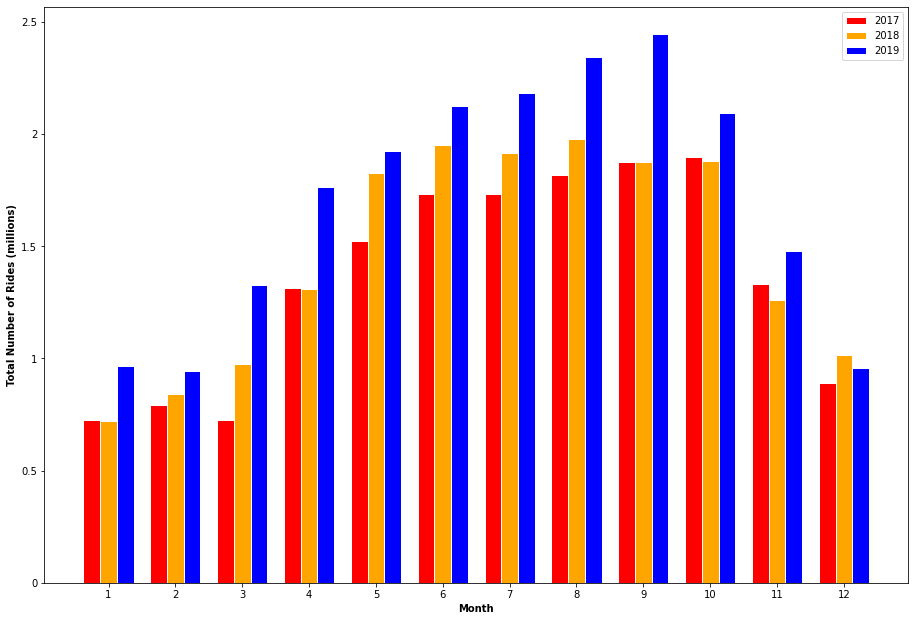

In [9]:
barWidth = 0.25
df['year'] = pd.to_datetime(df['start_date']).dt.year
growth = df.groupby(['year','month'],as_index = False).rides.sum()

bars1 = growth.loc[growth['year'] == 2017,'rides']
bars2 = growth.loc[growth['year'] == 2018,'rides']
bars3 = growth.loc[growth['year'] == 2019,'rides']


r1 = range(0,12)
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='2017')
plt.bar(r2, bars2, color='orange', width=barWidth, edgecolor='white', label='2018')
plt.bar(r3, bars3, color='blue', width=barWidth, edgecolor='white', label='2019')
 
# Add xticks on the middle of the group bars
plt.xlabel('Month', fontweight='bold')
plt.ylabel('Total Number of Rides (millions)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], [1,2,3,4,5,6,7,8,9,10,11,12])
plt.yticks(range(0,2500001,500000),[0,0.5,1,1.5,2,2.5]) 
# Create legend & Show graphic
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.legend()


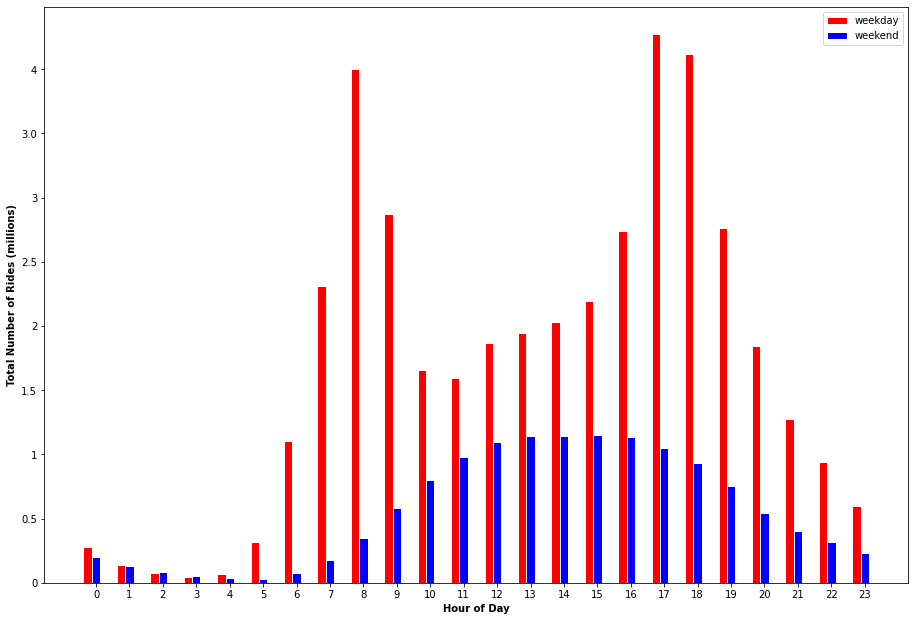

In [10]:
barWidth = 0.25

bars1 = df[df['dow'] < 5]
bars1 = bars1.groupby(['hod'],as_index = False).rides.sum()['rides']
bars2 = df[df['dow'] >= 5]
bars2 = bars2.groupby(['hod'],as_index = False).rides.sum()['rides']




r1 = range(0,24)
r2 = [x + barWidth for x in r1]


# Make the plot
plt.bar(r1, bars1, color='red', width=barWidth, edgecolor='white', label='weekday')
plt.bar(r2, bars2, color='blue', width=barWidth, edgecolor='white', label='weekend')

# Add xticks on the middle of the group bars
plt.xlabel('Hour of Day', fontweight='bold')
plt.ylabel('Total Number of Rides (millions)', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], range(0,24))
plt.yticks(range(0,4000001,500000),[0,0.5,1,1.5,2,2.5,3,3.,4]) 
# Create legend & Show graphic
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.legend()


In [11]:
bars1 = df[df['dow'] < 5]
bars1 = bars1.groupby(['hod'],as_index = False).rides.sum()['rides']
bars1.head()

0    279111
1    137101
2     74824
3     46267
4     70184
Name: rides, dtype: int64

# MAPS
Make map of stations that exist.

In [12]:
data_2017 = df.loc[df['start_date'] < '2018-01-01',['start_station_id','start_station_lat','start_station_long']].drop_duplicates()
nyc = df.loc[df['start_date'] >= '2019-01-01',['start_station_id','start_station_lat','start_station_long']].drop_duplicates(subset='start_station_id', keep='first').reset_index()

m = folium.Map(location=[40.7812, -73.9665], zoom_start=12)
for i in nyc.index:
    folium.Marker([nyc.loc[i,'start_station_lat'], nyc.loc[i,'start_station_long']],popup = nyc.loc[i,'start_station_id']).add_to(m)
data_2017.count()
nyc.count()

index                 936
start_station_id      936
start_station_lat     936
start_station_long    936
dtype: int64

# Scatter Plots
These are going to be important parts of my presentation.

## HOD Plot
This can be used to show that rush hour rides make up the majority.  We might want to split this out by day.

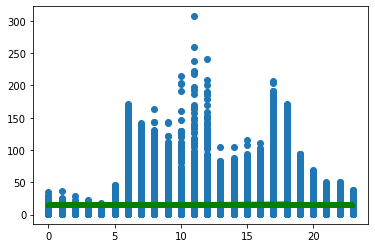

In [13]:
fitted = lowess(df['hod'], df['rides'])[:,1]
plt.scatter(df['hod'],df['rides'])
plt.plot(df['hod'],fitted,'green',linewidth=3)
plt.show()

# Weather Plots
## Max Temp

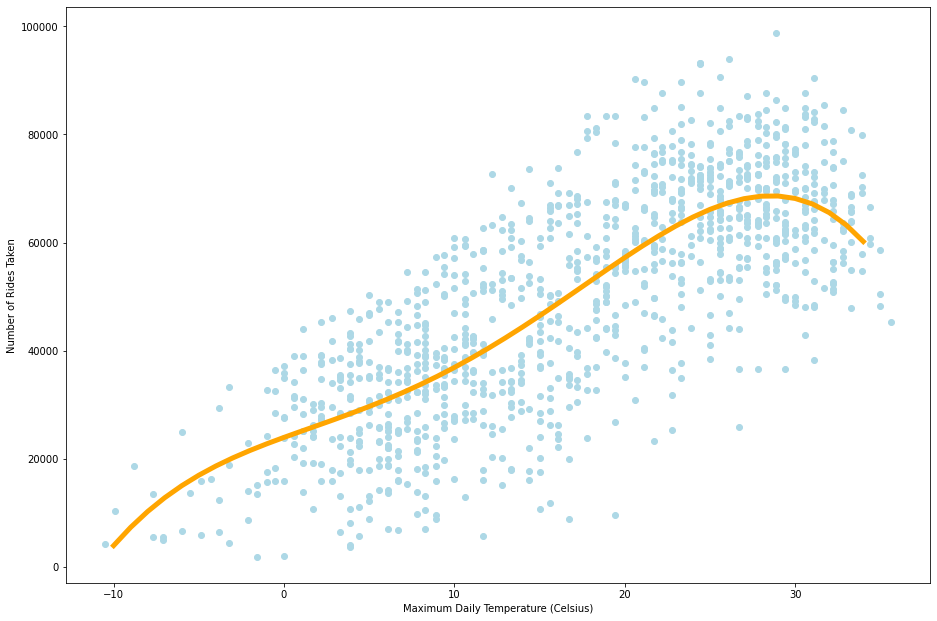

In [14]:
weather = df.groupby(['start_date','max_temp'],as_index = False).rides.sum()
x = np.array(weather['max_temp'])
y =np.array(weather['rides'])
m4, m3, m2 , m , b = np.polyfit(x, y, 4)
temp = np.arange(-10,35)
fitted = m * temp + m2 * (temp ** 2) + m3 * (temp ** 3)  + m4 * (temp ** 4)+ b
plt.scatter(weather['max_temp'],weather['rides'],color = 'lightblue')
plt.plot(temp,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Maximum Daily Temperature (Celsius)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.show()

## Precipitation

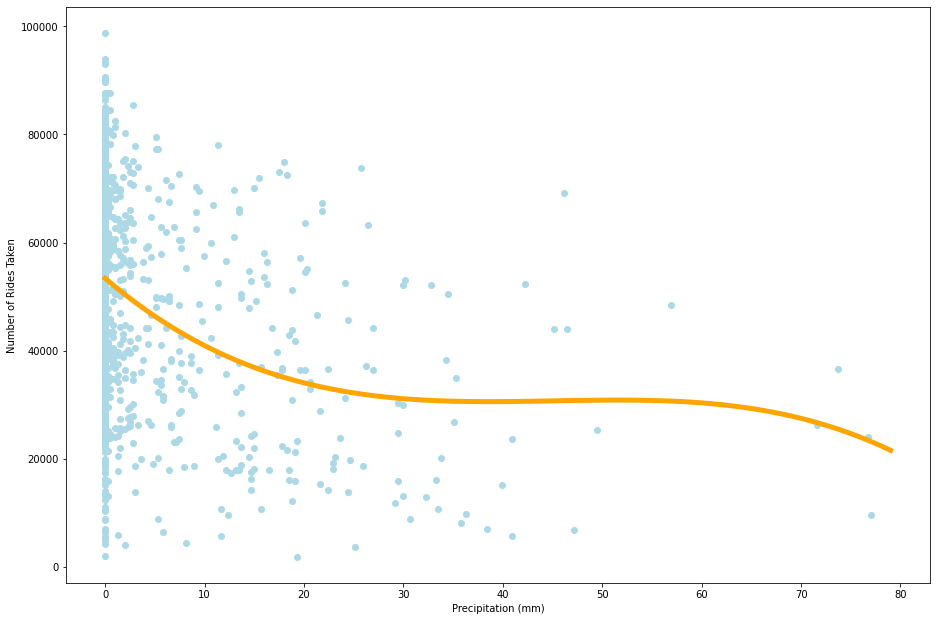

In [15]:
weather = df.groupby(['start_date','precipitation'],as_index = False).rides.sum()
x = np.array(weather['precipitation'])
y =np.array(weather['rides'])
m3 ,m2 , m , b = np.polyfit(x, y, 3)
temp = np.arange(0,80)
fitted = m * temp + m2 * (temp ** 2) + m3 * (temp ** 3) + b
plt.scatter(weather['precipitation'],weather['rides'],color = 'lightblue')
plt.plot(temp,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Precipitation (mm)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.show()

## Windspeed

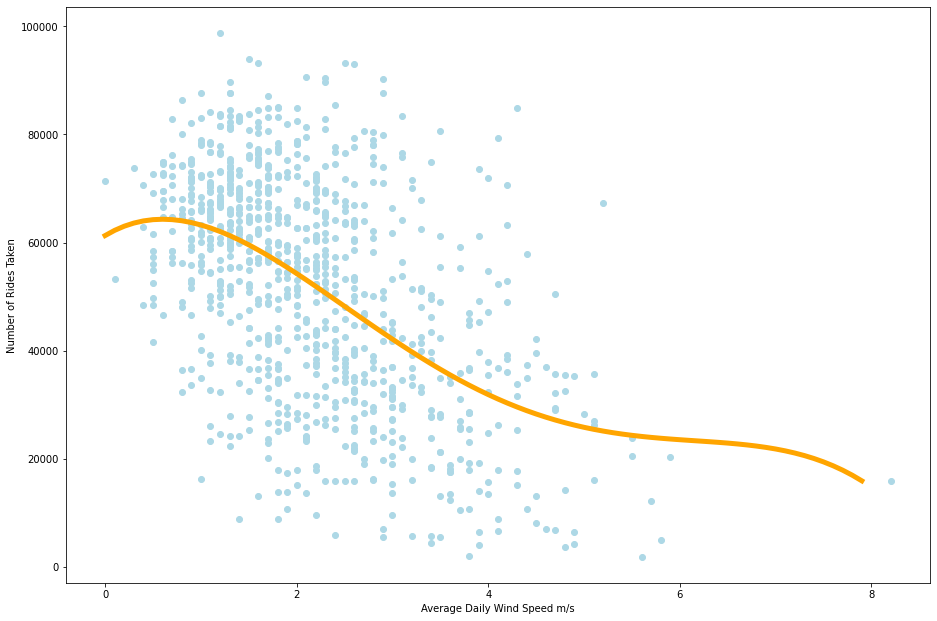

In [16]:
weather = df.groupby(['start_date','wind_speed'],as_index = False).rides.sum()
x = np.array(weather['wind_speed'])
y =np.array(weather['rides'])
m4, m3, m2 , m , b = np.polyfit(x, y, 4)
ws = np.arange(0,8,0.1)
fitted = m * ws + m2 * (ws ** 2) + m3 * (ws ** 3)  + m4 * (ws ** 4)+ b
plt.scatter(weather['wind_speed'],weather['rides'],color = 'lightblue')
plt.plot(ws,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Average Daily Wind Speed m/s')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)
plt.show()

## Distance to transit Plot

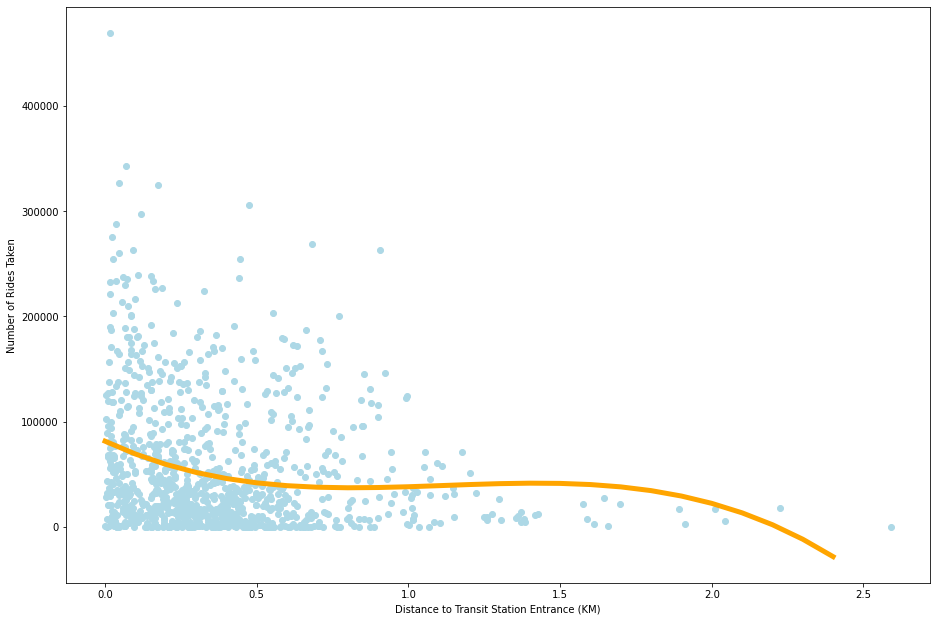

In [17]:
stations = df.groupby(['start_station_id','distance_to_transit'],as_index = False).rides.sum()
stations.sort_values(by=['distance_to_transit'])
x = np.array(stations['distance_to_transit'])
y =np.array(stations['rides'])
m3, m2 , m , b = np.polyfit(x, y, 3)
distance = np.arange(0,2.5,0.1)
fitted = m * distance + m2 * (distance ** 2) + m3 * (distance ** 3)  + b


plt.scatter(stations['distance_to_transit'],stations['rides'],color = 'lightblue')
plt.plot(distance,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Distance to Transit Station Entrance (KM)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)

## Altitude Plot

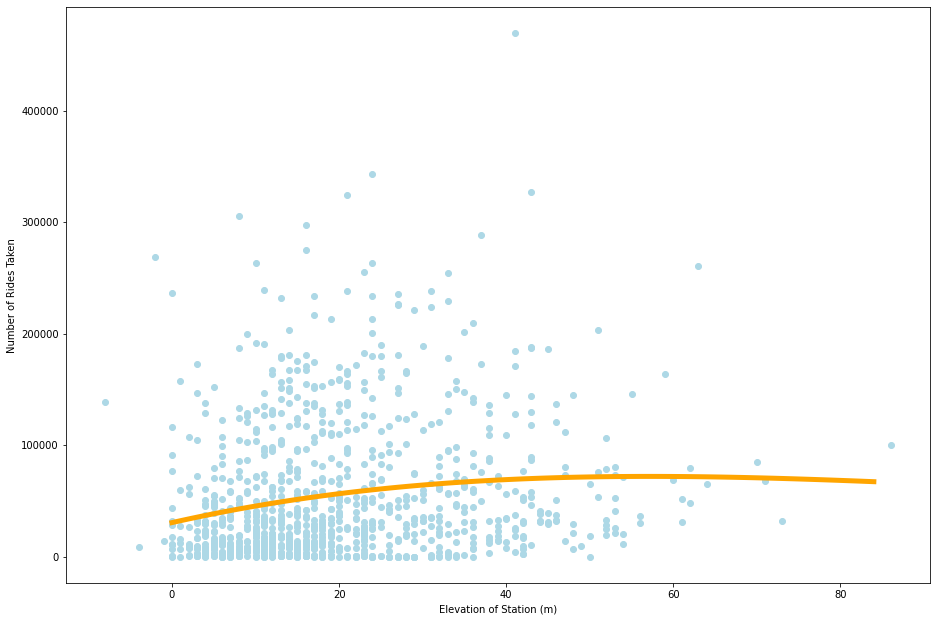

In [18]:
stations = df.groupby(['start_station_id','altitude'],as_index = False).rides.sum()
stations.sort_values(by=['altitude'])
x = np.array(stations['altitude'])
y =np.array(stations['rides'])
m3, m2 , m , b = np.polyfit(x, y, 3)
altitude = np.arange(0,85)
fitted = m * altitude + m2 * (altitude ** 2) + m3 * (altitude ** 3)  + b


plt.scatter(stations['altitude'],stations['rides'],color = 'lightblue')
plt.plot(altitude,fitted,color = 'orange',linewidth = 5)
plt.xlabel('Elevation of Station (m)')
plt.ylabel('Number of Rides Taken')
plt.subplots_adjust(left=0, bottom=0, right=2, top=2, wspace=0, hspace=0.2)

## JUST IN CASE CODE FOR SUBPLOTS
fig = plt.figure()
ax1 =  fig.add_subplot(211)
ax2 =  fig.add_subplot(212)
ax1.scatter(df['max_temp'],df['rides'],color = 'lightblue')
ax1.plot(temp,fitted,'green',linewidth=3)
ax1.set_xlabel('Average Daily Trips')
ax1.set_ylabel('Temperature in Celsius')
ax1.set_title('Number of Trips Ended at Each Station by Elevation')
ax2.scatter(df['precipitation'],df['rides'],color = 'lightblue')
ax2.set_xlabel('Average Daily Trips Ended')
ax2.set_ylabel('Elevation')
ax2.set_title('Number of Trips Ended at Each Station by Elevation')
